## Springboard Data Science Track: Capstone Two

# Bot Detection on Reddit

<i>Objective: To build a classifier that identifies Reddit users as 'bots' or 'non-bots'</i>

In the previous notebook I collected comments from users confirmed to be non-bots, and bots listed on the <a href='https://www.reddit.com/r/botwatch/comments/1xojwh/list_of_320_reddit_bots/'> r/botwatch</a> subreddit. 

## 2. Exploratory Data Analysis

 <ul>
    <li>Import Packages and Data</li>
    <li>Explore Data Sets</li>
    </ul>

### Step One: Import Packages and Data

In [50]:
#import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import csv
import datetime
import emoji

#settings
sns.set(style="whitegrid")
pd.options.mode.use_inf_as_na = True
pd.options.mode.chained_assignment = None  # default='warn'

In [51]:
#import comments csv
df = pd.read_csv('Data/All_Comments_Clean.csv')

#visual check
df.head(2)

,ID,Author,Comment,Subreddit,Score,Time,Flair,Class
0,e7wig3e,ADHDbot,Just dropping by to show that OP is completely misrepresenting the conversation\n\n&amp;#x200B;\n\n1. [https://i.imgur.com/Q9ePFI4.png](https://i.imgur.com/Q9ePFI4.png)\n\n&amp;#x200B;\n\n2. [https://i.imgur.com/jKiVMVc.png](https://i.imgur.com/jKiVMVc.png)\n\n&amp;#x200B;\n\n3. [https://i.imgur.com/JasrHdV.png](https://i.imgur.com/JasrHdV.png),unpopularopinion,4,2018-10-16 16:47:28,None,Bot
1,cww687m,ADHDbot,"As per the rules in the side bar, yes or no questions such as ""Does anyone else"" or ""Has anyone else"" (or variants thereof) are not allowed in post titles. Please repost with a more specific question, such as ""How do you manage this symptom?"" instead of ""Does anyone else have this symptom."" You'll get better answers and more replies. \n\nPlease see the rule explanation [here](http://www.reddit.com/r/adhd/wiki/rules#wiki_ask_a_question_that_can_be_answered_with_simply_yes_or_no).\n\nWe appreciate your understanding, thank you.\n\n\n*[I am a bot](/r/AutoModerator/comments/q11pu/what_is_automoderator/), and this action was performed automatically. No humans get notified of replies to this comment. Please [contact the moderators of this subreddit](/message/compose?to=%2Fr%2FADHD) if you have any questions or concerns.*",ADHD,1,2015-11-10 20:03:58,None,Bot


In [52]:
df.tail(2)

,ID,Author,Comment,Subreddit,Score,Time,Flair,Class
39240,dgga1g2,janellemonae,❤️,pics,3,2017-04-18 19:49:01,None,Non-Bot
39241,ddur7h1,janellemonae,Trying to get him to get an account so he can answer directly.,hiphopheads,253,2017-02-16 22:22:57,THE QUEEN,Non-Bot


In [53]:
len(df)

39242

### Step Two: Exploring the data sets

#### A. Score

The score is the total amount of upvotes/downvotes on the comment, as seen in the image below:

<img src="images/score.png">

In [54]:
#Summary Statistics
df.groupby('Class')['Score'].describe()

,count,mean,std,min,25%,50%,75%,max
Class,,,,,,,,
Bot,28962.0,3.594261,27.543548,-268.0,1.0,1.0,2.0,1752.0
Non-Bot,10280.0,91.162646,687.105605,-1120.0,1.0,1.0,5.0,32535.0


There are notable differences between the two groups:
    
<ul>
<li>The mean is much greater for Non-Bots (91) compared to bots (3.6)</li>
<li>The standard deviation is much greater for Non-Bots (687.10) compared to bots (27.54)</li>
<li>The max comment score for non-bots (32535) is much higher than bots (1752)</li>

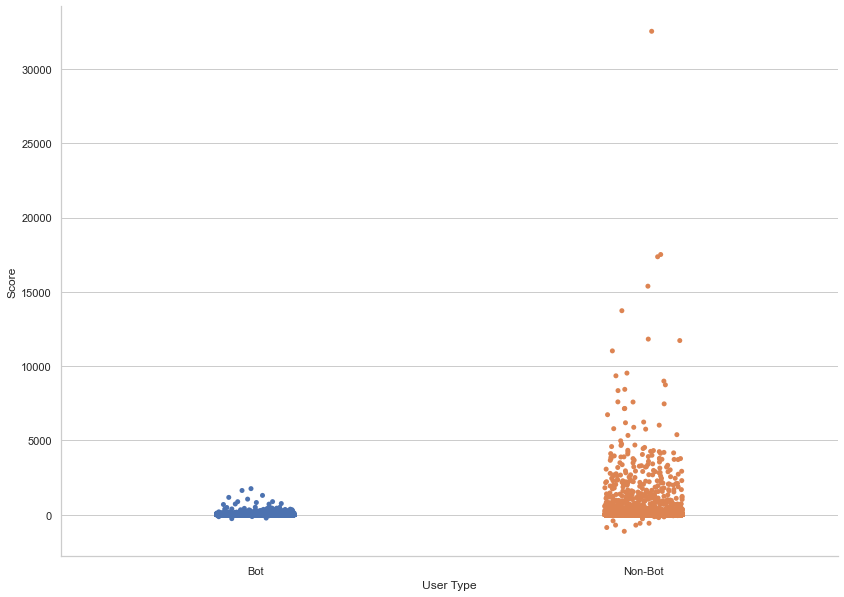

In [55]:
#Cat Plot of Score
sns.catplot(x="Class", y="Score", data=df, height=8.27, aspect=11.7/8.27, order=["Bot", "Non-Bot"])
plt.xlabel('User Type')

plt.show();

As we can see above, the score of 32535 is an outlier.

In [56]:
df.loc[df['Score'] == 32535]

,ID,Author,Comment,Subreddit,Score,Time,Flair,Class
38564,e2hglg7,PeterMayhew,"You might like them, if you give them a shot. I am a little biased, though.\n\nCheers, \n\nPeter Mayhew",AskReddit,32535,2018-07-16 08:15:33,None,Non-Bot


In [57]:
#Dropping Non-Bot Outlier
df.drop(df.index[df['Score'] == 32535], inplace = True)

In [58]:
df.shape

(39241, 8)

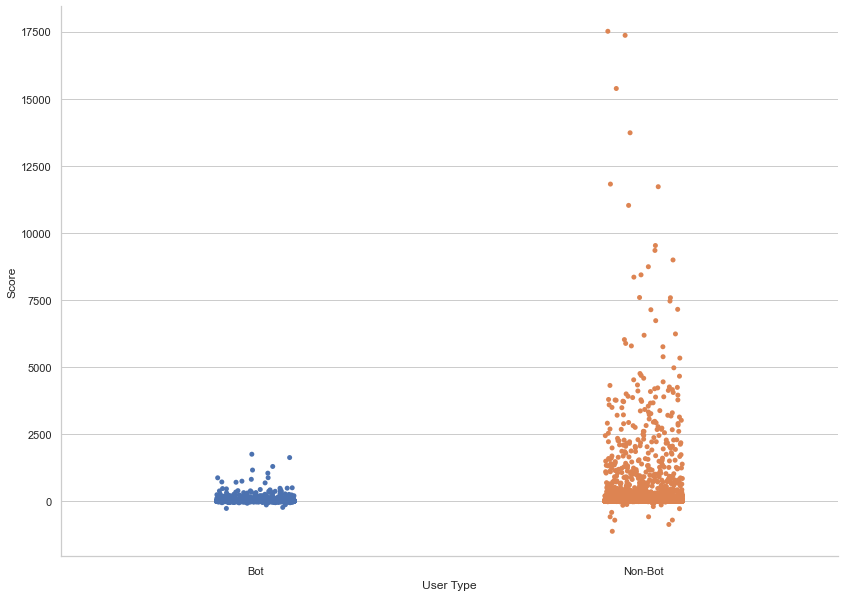

In [59]:
#Cat Plot of Score
sns.set(style="whitegrid")
sns.catplot(x="Class", y="Score", data=df, height=8.27, aspect=11.7/8.27, order=["Bot", "Non-Bot"])
plt.xlabel('User Type')

plt.show();

As we see above, non-bots have a much wider range of scores.

#### B. Subreddits

I'm curious to see if bots or non-bots post in a greater number of unique subreddits

In [60]:
#Summary Statistics
df.groupby('Class')['Subreddit'].describe()

,count,unique,top,freq
Class,,,,
Bot,28962,2742,AdviceAnimals,728
Non-Bot,10279,1055,AskReddit,1317


AskReddit was the most popular subreddit for non-bots, and AdviceAnimals for Bots.

In [61]:
#Calculate percentage unique
unique_sr = df.groupby('Class')['Subreddit'].nunique() / df.groupby('Class')['Subreddit'].count() * 100
print(unique_sr)

Class
Bot         9.467578
Non-Bot    10.263644
Name: Subreddit, dtype: float64


The percentage of unique subreddits posted in by bots and non-bots is similar.

#### C. Time

I'm interested in the total time span for each dataset, as well as how frequently bot and non-bot users post.

In [62]:
#Summary Statistics
df.groupby('Class')['Time'].min()

Class
Bot        2009-12-18 14:21:05
Non-Bot    2011-11-27 09:20:14
Name: Time, dtype: object

In [63]:
#Summary Statistics
df.groupby('Class')['Time'].max()

Class
Bot        2020-10-29 16:00:13
Non-Bot    2020-09-30 14:39:45
Name: Time, dtype: object

The date of non-bot comments ranges almost <b>nine years</b>, from November 27, 2011, to September 30, 2020, while the date of bot comments ranges almost <b>11 years</b> from 2009-12-18 to 2020-10-29.

In [64]:
df[df['Class'] == 'Bot'].tail(50)

,ID,Author,Comment,Subreddit,Score,Time,Flair,Class
28912,cp78v4t,acini,"Hey, thanks for reporting! This bot has already been reported. :)",BotWatchman,1,2015-03-07 06:28:49,gonna,Bot
28913,cp78q1l,acini,"Its active only in one sub, that also circlejerk one *shrugs shoulders*",BotWatchman,1,2015-03-07 06:21:23,gonna,Bot
28914,cp4oxvz,acini,triggered by simply a word 'joke',BotWatchman,1,2015-03-04 17:18:16,gonna,Bot
28915,cp1k19j,acini,It declares itself as bot in the footnote. Maybe it is triggered manually on specific comments.,BotWatchman,1,2015-03-01 21:08:11,gonna,Bot
28916,cp0p9ju,acini,It seems to be limited to few specific subs.,BotWatchman,1,2015-03-01 01:05:58,gonna,Bot
28917,cp0jb7s,acini,Nike,HouseOfCards,3,2015-02-28 20:05:05,None,Bot
28918,coxfqou,acini,Oh goddamned pestilence.,BotWatchman,1,2015-02-25 19:09:30,gonna,Bot
28919,cos9hz9,acini,"&gt;Not a biologist, but...\n\nAnd that's how I know I am on reddit for sure.",todayilearned,7,2015-02-20 21:20:02,1,Bot
28920,cohrzvn,acini,RemindMe! 10 days\n,BotWatchman,1,2015-02-10 19:23:38,gonna,Bot
28921,coeswky,acini,"Thanks for reporting. This is known bug, will be fixed soon. \n\nHave a nice day!",autowikibot,2,2015-02-07 22:53:13,None,Bot
